In [28]:
# mengimport library yang dibutuhkan

import pandas as pd
import numpy as np
import pathlib
import os
import zipfile
import tensorflow as tf

from tensorflow import keras
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply
from keras.layers import Dropout
from keras.layers import Input
from keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50 # pre-trained model

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn import metrics

# visualisasi
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
# mendowload dataset wheater image recognition
! pip install -q kaggle

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"suweshafiz","key":"fdc3447d065deab299d6c61cbbee4521"}'}

In [5]:
# membuat directory keaggle
! mkdir ~/.kaggle
# memindahkan kaggle.json ke directoy kaggle
! cp kaggle.json ~/.kaggle/
# mengganti permission data
! chmod 600 ~/.kaggle/kaggle.json
# mendowload dataset wheater image recognition
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d jehanbhathena/weather-dataset

 96% 565M/587M [00:02<00:00, 220MB/s]
100% 587M/587M [00:02<00:00, 240MB/s]


In [6]:
# mengekstrak file zip
local_zip = '/content/weather-dataset.zip'
local_unzip = zipfile.ZipFile(local_zip, 'r')
local_unzip.extractall('/content/')
local_unzip.close()
DATASET = '/content/dataset'

In [7]:
# menampilkan jumlah kelas
class_names = sorted(os.listdir(DATASET))
n_classes = len(class_names)

print(f"Total of Classes : {n_classes}")

Total of Classes : 11


In [8]:
# class distributions
class_dis = [len(os.listdir(DATASET + "/" + name)) for name in class_names]
class_dis

[698, 851, 475, 639, 591, 377, 526, 232, 1160, 692, 621]

In [9]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

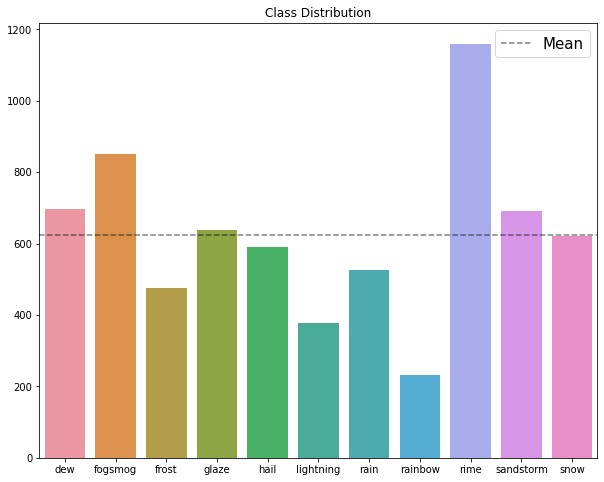

In [10]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dis
)
plt.axhline(np.mean(class_dis), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

In [11]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import splitfolders
splitfolders.ratio(DATASET,
                   output="split_dataset", # lokasi hasil split
                   seed=42, # jumlah arah
                   ratio=(.8, .2,), # 80% train dan 20% validation
                   group_prefix=None,
                   move=False
                   )

Copying files: 6862 files [00:02, 2670.85 files/s]


In [13]:
# menghitung total file data
datacount = 0
for root_dir, cur_dir, files in os.walk('/content/split_dataset/train'):
  datacount += len(files)
print('TOTAL DATASET TRAIN IMAGE : ', datacount)
datacount2 = 0
for root_dir, cur_dir, files in os.walk('/content/split_dataset/val'):
  datacount2 += len(files)
print('TOTAL DATASET VALIDATION IMAGE : ', datacount2)

TOTAL DATASET TRAIN IMAGE :  5484
TOTAL DATASET VALIDATION IMAGE :  1378


In [14]:
validation_size = 0.2

Train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    brightness_range = [0.1,1],
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode = 'nearest',
    validation_split = validation_size
)

Validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    brightness_range = [0.1,1],
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode = 'nearest',
    validation_split = validation_size
)

In [15]:
train_generator = Train_datagen.flow_from_directory(DATASET,
                                                 target_size=(256,256),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 subset='training')

val_generator = Validation_datagen.flow_from_directory(DATASET, 
                                                 target_size=(256,256),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 subset='validation')

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


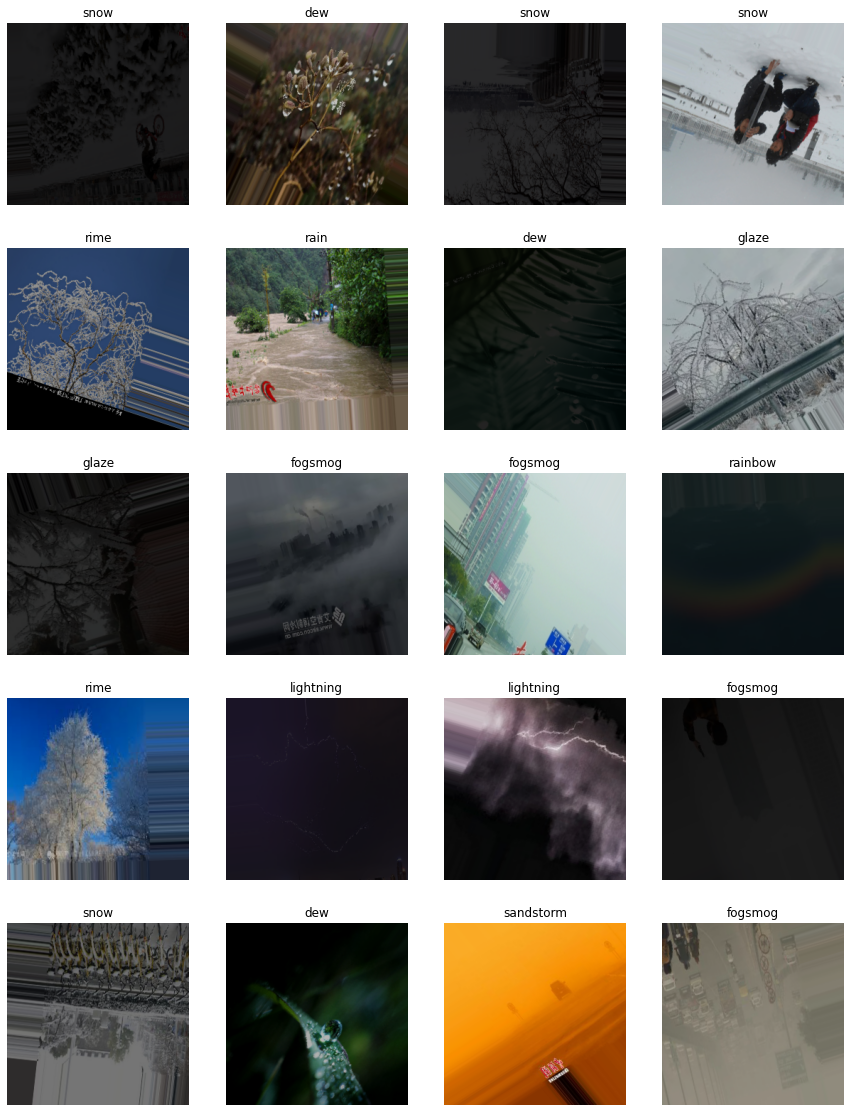

In [16]:
# view data

i=1
plt.figure(figsize=(15,20))
for images, labels in train_generator:
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])

    plt.subplot(5, 4, i)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')

    i+=1
    if i>=21: break

plt.show()

In [17]:
# ResNet152V2

name = 'resnet'
# TL Model
base_model = ResNet152V2(include_top=False, input_shape=(256,256,3))
base_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [18]:
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
])


# penggunaan optimizer Adam
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [19]:
cbs = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

In [22]:
# membuat callback dengan on_epoch_end

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')> 0.83 and logs.get('val_accuracy')> 0.83):
      print("\nTrain dan Validation Accuracy berada diatas 80%")
      self.model.stop_training = True
callbacks = myCallback()

In [23]:
# training model dengan learning rate shedule dan callback

step_size_train = train_generator.n//train_generator.batch_size
step_size_test  = val_generator.n//val_generator.batch_size

history = model.fit(
          train_generator,
          steps_per_epoch = step_size_train,
          epochs = 10,
          validation_data = val_generator,
          validation_steps = step_size_test,
          callbacks = [callbacks]
          )

Epoch 1/10
171/171 [==============================] - 3769s 22s/step - loss: 1.2016 - accuracy: 0.6004 - val_loss: 0.7111 - val_accuracy: 0.7567
Epoch 2/10
171/171 [==============================] - 3750s 22s/step - loss: 0.7894 - accuracy: 0.7281 - val_loss: 0.6088 - val_accuracy: 0.8051
Epoch 3/10
171/171 [==============================] - 3724s 22s/step - loss: 0.7101 - accuracy: 0.7572 - val_loss: 0.6353 - val_accuracy: 0.7835
Epoch 4/10
171/171 [==============================] - 3742s 22s/step - loss: 0.6418 - accuracy: 0.7771 - val_loss: 0.5814 - val_accuracy: 0.7954
Epoch 5/10
171/171 [==============================] - 3741s 22s/step - loss: 0.6070 - accuracy: 0.7909 - val_loss: 0.5551 - val_accuracy: 0.8140
Epoch 6/10
171/171 [==============================] - 3750s 22s/step - loss: 0.5801 - accuracy: 0.8011 - val_loss: 0.5560 - val_accuracy: 0.8110
Epoch 7/10
171/171 [==============================] - 3724s 22s/step - loss: 0.5629 - accuracy: 0.8061 - val_loss: 0.5264 - val_ac

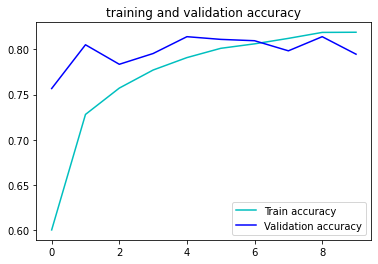

<Figure size 432x288 with 0 Axes>

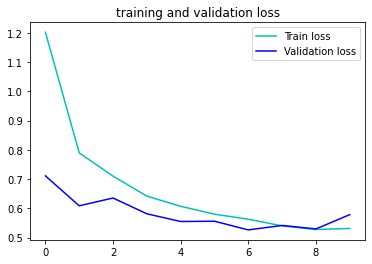

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning:

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.



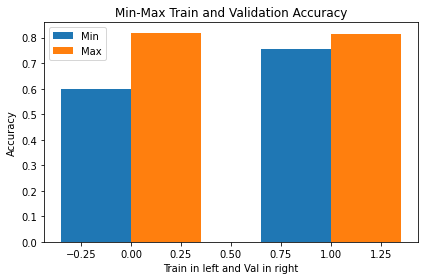



__________________________________________________
                     SUMMARY                      
Min train accuracy  :  0.60044
Max train accuracy  :  0.8189
Min validation accuracy  :  0.7567
Max validation accuracy  :  0.81399
__________________________________________________
Min train loss  :  0.52771
Max train loss  :  1.20164
Min validation loss  :  0.52636
Max validation loss  :  0.71108
__________________________________________________


In [24]:
# mengevaluasi model dengan plot accuracy dan loss
log_acc = history.history['accuracy']
log_val_acc = history.history['val_accuracy']
log_loss = history.history['loss']
log_val_loss = history.history['val_loss']

epochs = range(len(log_acc))



# ploting accuracy
plt.title('training and validation accuracy')
plt.plot(epochs, log_acc, 'c', label='Train accuracy')
plt.plot(epochs, log_val_acc, 'b', label='Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# ploting loss
plt.title('training and validation loss')
plt.plot(epochs, log_loss, 'c', label='Train loss')
plt.plot(epochs, log_val_loss, 'b', label='Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# grouped bar min dan max accuracy
labels = ['Train Accuracy', 'Validation Accuracy']
min_acc = [(min(log_acc)),(min(log_val_acc))]
max_acc = [(max(log_acc)),(max(log_val_acc))]

xi = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
min_bar = ax.bar(xi - width/2, min_acc, width, label='Min')
max_bar = ax.bar(xi + width/2, max_acc, width, label='Max')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Train in left and Val in right')
ax.set_title('Min-Max Train and Validation Accuracy')
ax.set_xticks(xi,labels)
ax.legend()

fig.tight_layout()
plt.show()



# menampilkan min dan max accuracy
def view_summary(nm,la,mm):
  print(nm, ' : ', float(f'{(mm(la)):.05f}'))

def ln(opt):
  if opt == 1:
    print("_"*50)
  elif opt == 2:
    print('='*50)
  else:
    print('-'*50)

print('\n')
ln(1)
print('SUMMARY'.center(50))
ln(2)
# memanggil fungsi view_summary
view_summary('Min train accuracy',log_acc,min)
view_summary('Max train accuracy',log_acc,max)
view_summary('Min validation accuracy',log_val_acc,min)
view_summary('Max validation accuracy',log_val_acc,max)
ln(1)
view_summary('Min train loss',log_loss,min)
view_summary('Max train loss',log_loss,max)
view_summary('Min validation loss',log_val_loss,min)
view_summary('Max validation loss',log_val_loss,max)
ln(1)

In [25]:
# menyimpan model dalam format SavedModel
EXPORT_DIR = 'saved_model/'
tf.saved_model.save(model, EXPORT_DIR)

In [26]:
# mengconvert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(EXPORT_DIR)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

235051308

In [27]:
model.save("model.h5")

1/1 [==============================] - 1s 673ms/step


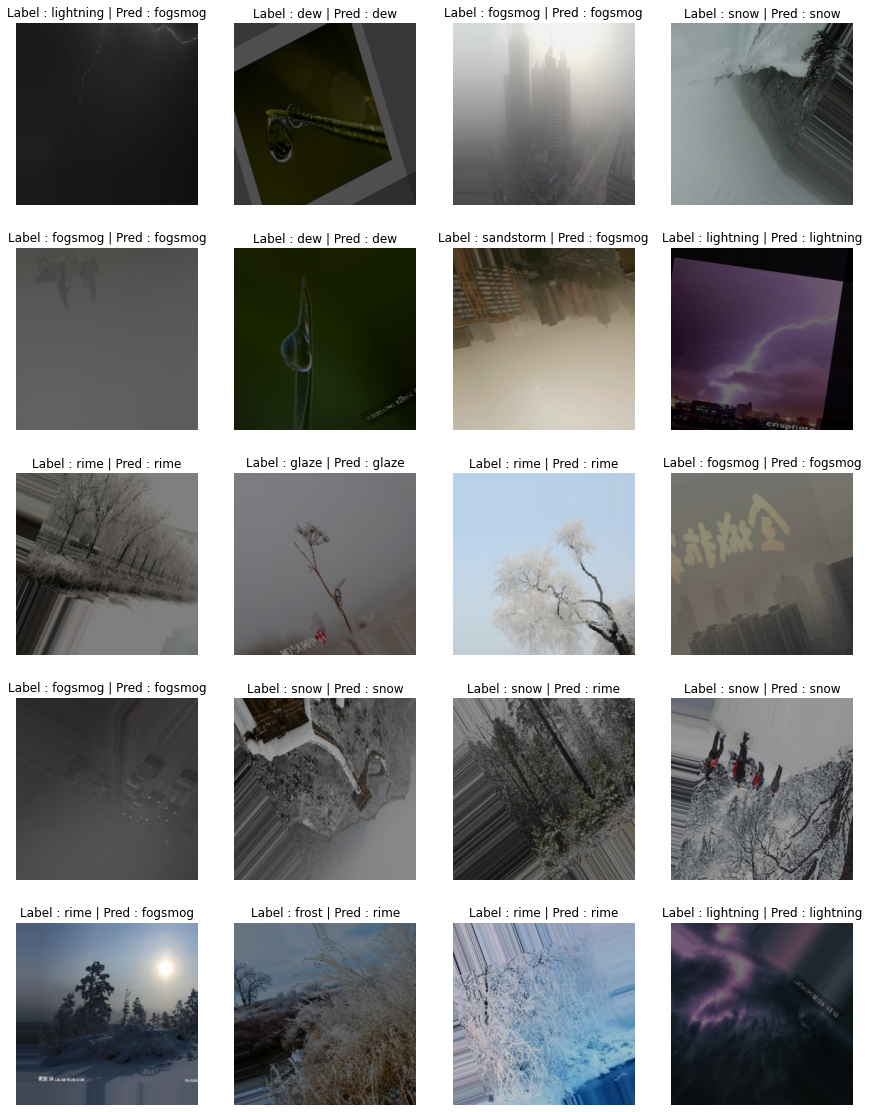

In [30]:
model = load_model("/content/model.h5")
i=1
plt.figure(figsize=(15,20))
for images, labels in train_generator:
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])
    pred_label = class_names[np.argmax(model.predict(image[np.newaxis,...]))]

    plt.subplot(5, 4, i)
    plt.imshow(image)
    plt.title(f"Label : {class_names[label]} | Pred : {pred_label}")
    plt.axis('off')

    i+=1
    if i>=21: break

plt.show()